In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
from scipy.optimize import curve_fit

from utils import analysis, utils, files # sibling package...

In [ ]:
experiment = "emg_olympics"
subject = "bob"


## reach variance

In [ ]:
ed = files.build_experiment_path_dict(experiment)
print(ed["subjects"].keys())
if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

data folder:  /mnt/c/Users/spencer/data/emg_olympics
dict_keys(['andy', 'bob', 'dammy', 'matthias', 'miranda', 'peter'])
/mnt/c/Users/spencer/data/emg_olympics/bob/center_hold/session_0
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


In [ ]:
if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

/mnt/c/Users/spencer/data/emg_olympics/bob/center_hold/session_0
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


In [ ]:
if not center_hold_session is None:
    concat_center_hold_data = utils.concat_emg_trials(chd)[:,:64]
    concat_center_hold_data = analysis.highpass(concat_center_hold_data,cutoff=3)
    print(concat_center_hold_data.shape)
    center_hold_vars = np.std(concat_center_hold_data, axis=0)
    center_hold_means = np.mean(concat_center_hold_data, axis=0)

(122420, 64)


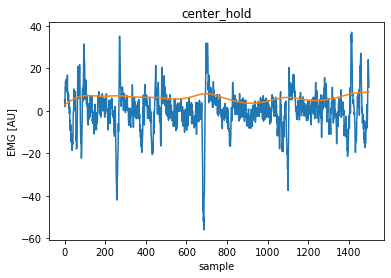

In [ ]:
start=3000
stop = 4500
channel=11
low_cutoff=5
if not center_hold_session is None:
    plt.figure()
    hp = concat_center_hold_data[start:stop]
    lp = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

(122420, 64)


No handles with labels found to put in legend.


-0.02411959868091181 4.209512924577172
min channel:  14
7.675474382647274e-05 4.209512924577172
(122420, 64)


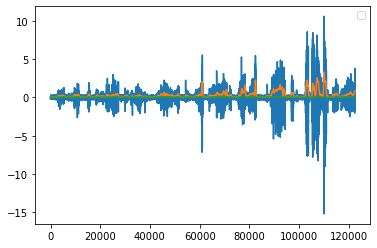

In [ ]:
vars = np.diag(utils.load_array_from_disk(subject_metadata_folder / "variance.bin",dtype=np.float32).reshape(64,64)).reshape(64)**-1
end=-1
if not center_hold_session is None:
    standardized_center_hold_data = utils.standardize(concat_center_hold_data, vars)
    filtered_center_hold_data = utils.filter_emg(standardized_center_hold_data)
    # offset_center_hold_data = np.subtract(filtered_center_hold_data,offsets)
    plt.plot(standardized_center_hold_data[:end,channel])
    plt.plot(filtered_center_hold_data[:end,channel])
    # plt.plot(offset_center_hold_data[:end,channel],label="offset")
    if end == -1:
        plt.plot([0,filtered_center_hold_data.shape[0]],[0,0])
    else:
        plt.plot([0,end],[0,0])
    plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


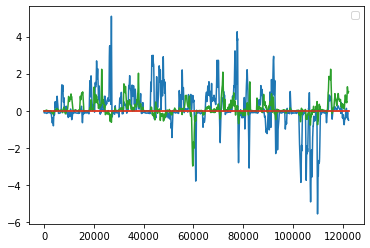

In [ ]:
decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)

# 2D preview
fig, ax = plt.subplots(1,1)
for c in decoder[-2:]:
    # baseline = np.dot(c,filtered_movement_data.T)
    baseline = np.dot(c,filtered_center_hold_data.T)
    ax.plot(baseline)
    ax.plot([0,baseline.shape[0]],[0,0])
    ax.legend()

In [ ]:
x = np.arange(10).reshape(10,1)
y = np.arange(10).reshape(10,1)
pts = np.hstack([x,y])
print(pts.shape)
lengths = np.sqrt(np.sum(np.diff(pts, axis=0)**2, axis=1)) # Length between corners
print(lengths)
total_length = np.sum(lengths)
print(total_length)

(10, 2)
[1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.41421356 1.41421356]
12.727922061357857


# PCA

In [ ]:
# get components -- channel-wise covariance
num_components = 3
pca_model = PCA(n_components=num_components)
pca_model.fit(filtered_calibration_data)
pca_components = pca_model.components_
print(pca_components.shape)

In [ ]:
# screeplots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(pca_components[i].reshape(8,8),vmin=np.min(pca_components),vmax=np.max(pca_components))
    ax.set_title(str(i))

plt.figure()
plt.plot(pca_components[0]*np.sqrt(pca_model.singular_values_[0]))
plt.plot(movement_vars)

In [ ]:
print(np.dot(components[0],components[1]))
print(np.dot(components[1],components[1]))
print(np.linalg.norm(components[0]))

# factor analysis

https://stackoverflow.com/questions/37221635/rotation-argument-for-scikit-learns-factor-analysis
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA
https://scikit-learn.org/stable/auto_examples/decomposition/plot_varimax_fa.html#sphx-glr-auto-examples-decomposition-plot-varimax-fa-py
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
https://scikit-learn.org/stable/modules/decomposition.html#fa

In [ ]:
model = FactorAnalysis(n_components=num_components, random_state=0)
model.fit(standardized_data)
factors = model.components_
print(factors.shape)

In [ ]:
print(factors[0].shape)
print(np.dot(factors[0]/np.linalg.norm(factors[0]),
             factors[1]/np.linalg.norm(factors[1])))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,65), model.mean_)
ax1.set_ylabel("feature mean")
ax1.set_xlabel("feature")

ax2.plot(range(1,65), model.noise_variance_)
ax2.set_ylabel("feature noise variance")
ax2.set_xlabel("feature")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(factors[i].reshape(8,8))
    ax.set_title(str(i))